In [126]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [6]:
def f(x):
  return 3*x**2 - 4*x + 5


In [7]:
f(3.0)

20.0

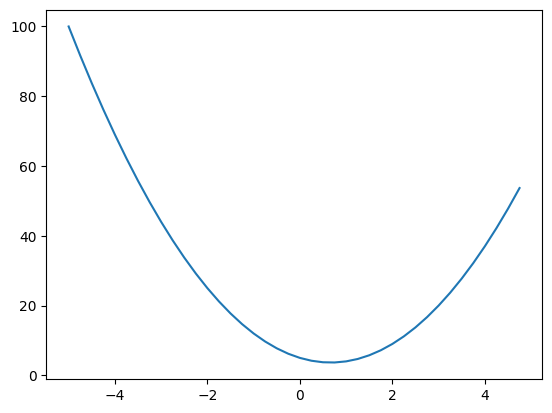

In [14]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
ys
plt.plot(xs,ys)

In [18]:
h= 0.0000001
x=2/3
(f(x+h)-f(x))/h

2.9753977059954195e-07

In [22]:
h=0.001

a=2.0
b=-3.0
c=10.0
d=a*b+c

d1=a*b+c
a += h
d2 = a*b+c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 3.997
slope -3.0000000000001137


In [115]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [68]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

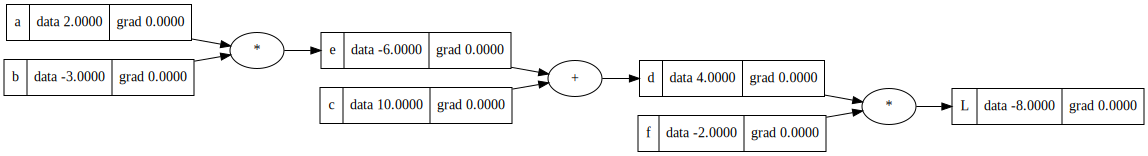

In [116]:
draw_dot(L)

In [61]:
a.data += 0.01* a.grad
b.data += 0.01* b.grad
c.data += 0.01* c.grad
f.data += 0.01* f.grad

e= a*b
d = e+c
L= d*f

print(L.data)

-10.547552000000005


In [117]:
def haha():
  h=0.0001

  a= Value(2.0,label='a')
  b= Value(-3.0,label='b')
  c=Value(10.0,label='c')
  e=a*b;e.label='e'
  d=e+c;d.label='d'
  f=Value(-2.0,label='f')
  L=d*f;L.label='L'
  L1 = L.data

  a= Value(2.0+h,label='a')
  b= Value(-3.0,label='b')
  c=Value(10.0,label='c')
  e=a*b;e.label='e'
  d=e+c;d.label='d'
  f=Value(-2.0,label='f')
  L=d*f;L.label='L'
  L2 = L.data

  print((L2-L1)/h)

haha()

6.000000000021544


<function matplotlib.pyplot.grid(visible: 'bool | None' = None, which: "Literal['major', 'minor', 'both']" = 'major', axis: "Literal['both', 'x', 'y']" = 'both', **kwargs) -> 'None'>

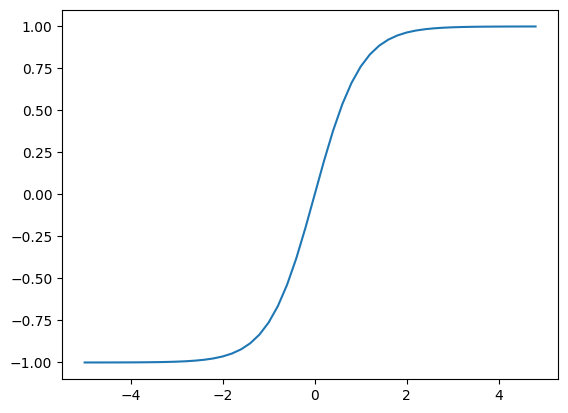

In [69]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));plt.grid

In [119]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.88, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

In [120]:
o.grad=1.0

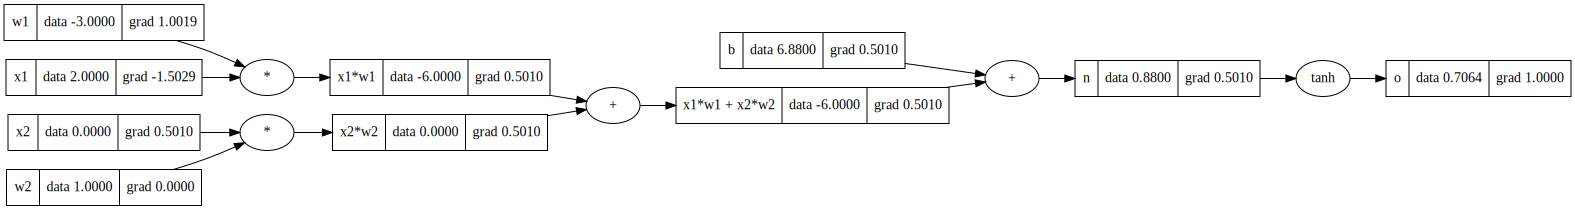

In [121]:
draw_dot(o)

In [123]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.881]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [124]:
torch.Tensor([2.0]).double().dtype

torch.float64

In [125]:
o.item()

0.7071066904050358

In [135]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7706105089305811)

In [136]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.7706105089305811),
 Value(data=0.7081420327423698),
 Value(data=0.7906517538685156),
 Value(data=0.7415785020458664)]

In [139]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.243584116871571)

In [140]:
loss.backward()

In [142]:
n.layers[0].neurons[0].w[0].grad

0.15911743065215367

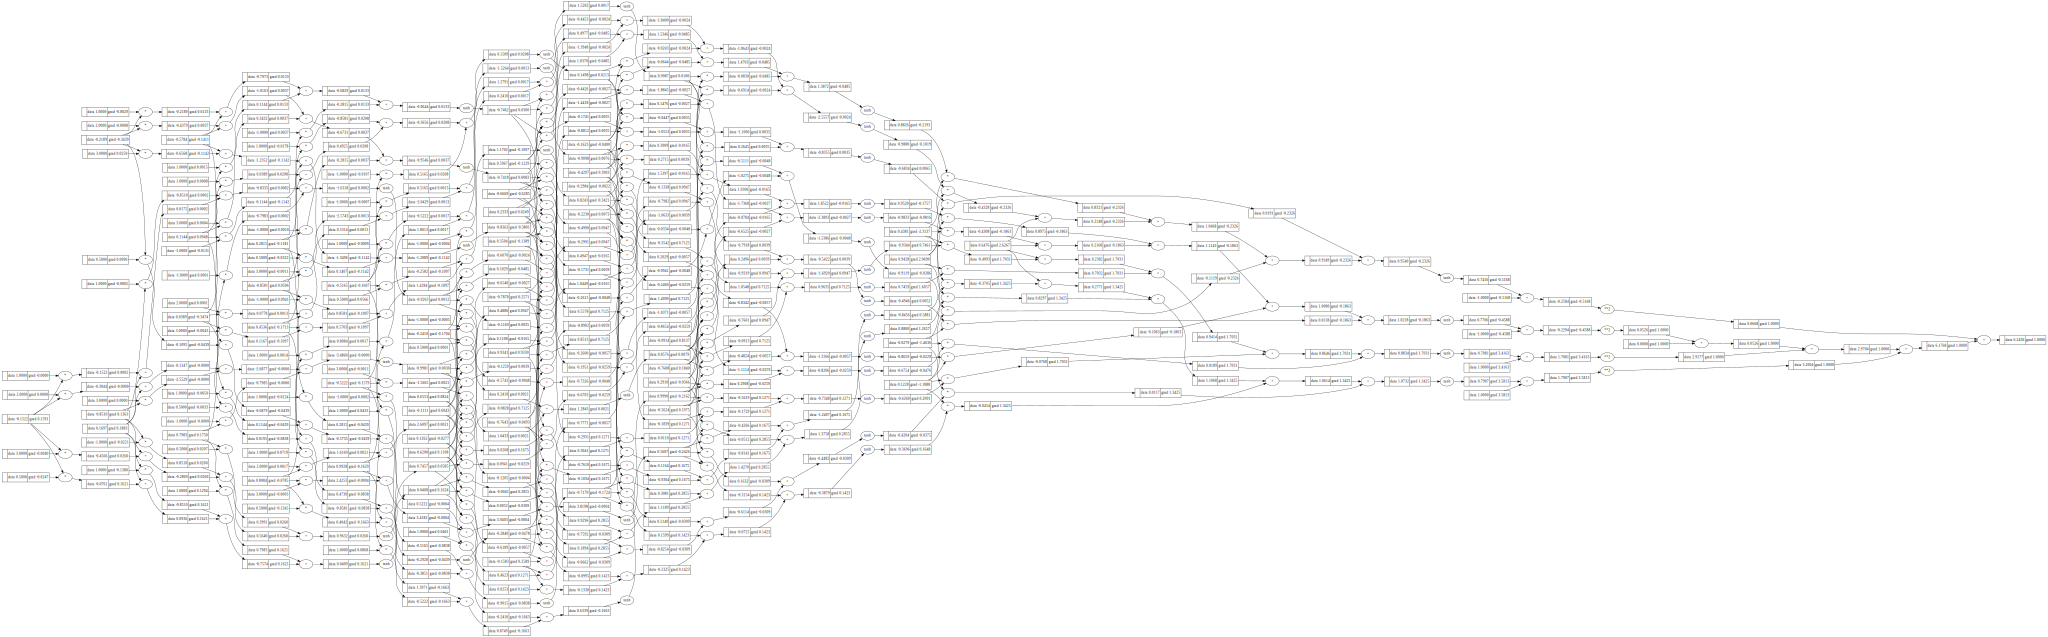

In [143]:
draw_dot(loss)

In [144]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [145]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8765279907195918)

In [147]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [149]:
n.parameters()

[Value(data=-0.4169453278282931),
 Value(data=0.9222102042619804),
 Value(data=0.510625447445888),
 Value(data=0.20110587359539944),
 Value(data=-0.021085935432486602),
 Value(data=-0.13562685544980013),
 Value(data=-0.699383596827037),
 Value(data=0.7864122320329769),
 Value(data=-0.8753745482430304),
 Value(data=0.552843298565207),
 Value(data=-0.9814198509077641),
 Value(data=0.24550872219392672),
 Value(data=0.9827766004790315),
 Value(data=0.34444921313858967),
 Value(data=0.3844254101703031),
 Value(data=-0.7718749669974267),
 Value(data=0.7525071512367467),
 Value(data=0.7179325358869295),
 Value(data=-0.7125494478761445),
 Value(data=-0.8403089617033017),
 Value(data=-0.9146623331822874),
 Value(data=0.699504508663207),
 Value(data=0.4719125079154569),
 Value(data=0.8233011167356616),
 Value(data=0.5496989736131797),
 Value(data=0.04028763076017294),
 Value(data=0.8102636870554809),
 Value(data=-0.0385542991487815),
 Value(data=0.8142448901531825),
 Value(data=-0.49199078423109

In [150]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 2.9874611305554954
1 1.4388572578997412
2 1.5921321590012414
3 0.03287293305450159
4 0.027645952782630143
5 0.023925054032090776
6 0.021123747316668308
7 0.018930935336670826
8 0.017163949390465245
9 0.015707632969302658
10 0.014485439095332144
11 0.01344433912006677
12 0.012546354445764563
13 0.011763528400044042
14 0.011074801116303134
15 0.010463992249786416
16 0.009918456540344477
17 0.009428162938155455
18 0.008985048692218044
19 0.008582556768505008


In [151]:
ypred

[Value(data=0.9537476588329775),
 Value(data=-0.949333985121598),
 Value(data=-0.9882771135572667),
 Value(data=0.9388542186666432)]